# Part 2: Training an ML Model

This part of the MLRun getting-started tutorial walks you through the steps for training a machine-learning (ML) model, including data exploration and model testing.

The tutorial consists of the following steps:

1. [Setup and Configuration](#gs-tutorial-2-step-setup)
2. [Creating a training function](#gs-tutorial-2-step-create-a-training-function)
3. [Exploring the data with an MLRun marketplace function](#gs-tutorial-2-step-explore-data-w-mlrun-func)
4. [Testing your model](#gs-tutorial-2-step-test-model)

By the end of this tutorial you'll learn how to

- Create a training function, store models, and track experiments while running them.
- Use artifacts as inputs to functions.
- Leverage the MLRun functions marketplace.
- View plot artifacts.

<a id="gs-tutorial-2-prerequisites"></a>

## Prerequisites

The following steps are a continuation of the previous part of this getting-started tutorial and rely on the generated outputs.
Therefore, make sure to first run [part 1](01-mlrun-basics.ipynb) of the tutorial.

<a id="gs-tutorial-2-step-setup"></a>

## Step 1: Setup and Configuration

<a id="gs-tutorial-2-mlrun-envr-init"></a>

### Initializing Your MLRun Environment

Use the `get_or_create_project` MLRun method to create a new project or fetch it from the DB/repository if it already exists.
Set the `project` and `user_project` parameters to the same values that you used in the call to this method in the [Part 1: MLRun Basics](./01-mlrun-basics.ipynb#gs-tutorial-1-set-mlrun-envr) tutorial notebook.

In [1]:
import mlrun

# Set the base project name
project_name_base = 'getting-started'

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name_base, context="./", user_project=True)

> 2021-09-09 03:29:54,129 [info] loaded project getting-started from MLRun DB


<a id="gs-tutorial-2-mark-mlrun-code-start"></a>

### Marking The Beginning of Your Function Code

The following code uses the `# mlrun: start-code` marker comment annotation to instruct MLRun to start processing code only from this location.

> **Note:** You can add code to define function dependencies and perform additional configuration after the `# mlrun: start-code` marker and before [the `# mlrun: end-code` marker](#gs-tutorial-2-mark-mlrun-code-end).

In [2]:
# mlrun: start-code

<a id="gs-tutorial-2-step-create-a-training-function"></a>

## Step 2: Creating a Training Function

Training functions generate models and various model statistics, we want to store the models along will all the relevant data, metadata and measurements. This can be achieved automatically using MLRun `auto logging` capabilities. 

MLRun can apply all the MLOps functionality by simply using the framework specific `apply_mlrun()` method which manages the training process and automatically logs all the framework specific model details, data, metadata and metrics. 

To log the training results and store a model named `my_model`, we simply need to add the following lines:

``` python
from mlrun.frameworks.sklearn import apply_mlrun
apply_mlrun(model, context, model_name='my_model', X_test=X_test, y_test=y_test)
```

The training job will automatically generate a set of results and versioned artifacts (run `train_run.outputs` to view the job outputs):

```python
{'accuracy': 1.0,
 'test-error': 0.0,
 'auc-micro': 1.0,
 'auc-weighted': 1.0,
 'f1-score': 1.0,
 'precision_score': 1.0,
 'recall_score': 1.0,
 'confusion-matrix': 'v3io:///projects/getting-started-iguazio/artifacts/plots/confusion-matrix.html',
 'precision-recall-multiclass': 'v3io:///projects/getting-started-iguazio/artifacts/plots/precision-recall-multiclass.html',
 'roc-multiclass': 'v3io:///projects/getting-started-iguazio/artifacts/plots/roc-multiclass.html',
 'test_set': 'store://artifacts/getting-started-iguazio/train-iris-train_iris_test_set:1efe6003e658450db242056d1516fb85',
 'my_model': 'store://artifacts/getting-started-iguazio/my_model:1efe6003e658450db242056d1516fb85'}
```


In [3]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from mlrun.frameworks.sklearn import apply_mlrun

import mlrun

In [4]:
def train_iris(context: mlrun.MLClientCtx,
               dataset: mlrun.DataItem,
               label_column: str):
    
    # Initialize our dataframes
    df = dataset.as_df()
    X = df.drop(label_column, axis=1)
    y = df[label_column]

    # Train/Test split Iris data-set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Pick an ideal ML model
    model = ensemble.RandomForestClassifier()
    
    # Wrap our model with Mlrun features, specify the test dataset for analysis and accuracy measurements
    apply_mlrun(model, context, model_name='my_model', X_test=X_test, y_test=y_test)
    
    # Train our model
    model.fit(X_train, y_train)

<a id="gs-tutorial-2-mark-mlrun-code-end"></a>

### Marking The End of Your Function Code

The following code uses the `# mlrun: end-code` marker code annotation to mark the end of the code section that should be converted to your MLRun function (which began with [the `# mlrun: start-code` annotation](#gs-tutorial-2-mark-mlrun-code-start)) and instruct MLRun to stop parsing the notebook at this point.

> **Important:** Don't remove the start-code and end-code annotation cells.

In [5]:
# mlrun: end-code

### Converting the Code to an MLRun Function

Use the MLRun `code_to_function` method to convert the selected portions of your notebook code into an MLRun function in your project &mdash; a function object with embedded code, which can run on the cluster.

The following code converts the code of your local `train_iris` function, which is defined within `# mlrun: start-code` and `# mlrun: end-code` annotations that mark the notebook code to convert (see the previous code cells), into into a `train_iris_func` MLRun function.
The function will be stored and run under the current project (which was specified in the `get_or_create_project` method above).  

The code sets the following `code_to_function` parameters:

- `name` &mdash; the name of the new MLRun function (`train_iris`).
- `handler` &mdash; the name of the function-handler method (`train_iris`; the default is `main`).
- `kind` &mdash; the function's runtime type (`job` for a Python process).
- `image` &mdash; the name of the container image to use for running the job &mdash; "mlrun/mlrun".
    This image contains the basic machine-learning Python packages (such as scikit-learn).

In [6]:
train_iris_func = mlrun.code_to_function(name='train_iris',
                                         handler='train_iris',
                                         kind='job',
                                         image='mlrun/mlrun')

<a id="gs-tutorial-2-persistent-volume-mount"></a>

### Running the Function on a Cluster


In [7]:
# Our dataset location (uri)
dataset = project.get_artifact_uri('prep_data_cleaned_data')

> 2021-09-09 03:30:04,779 [info] starting run train-iris-train_iris uid=1676f91b289d48ba9fc6b0b81c9cade5 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iguazio,...1c9cade5,0,Sep 09 03:30:04,completed,train-iris-train_iris,v3io_user=iguaziokind=owner=iguaziohost=jupyter-7d576855f5-ngqd5class=RandomForestClassifier,dataset,label_column=label,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_setmy_model


> 2021-09-09 03:30:06,142 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

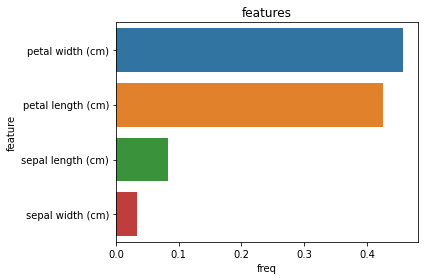

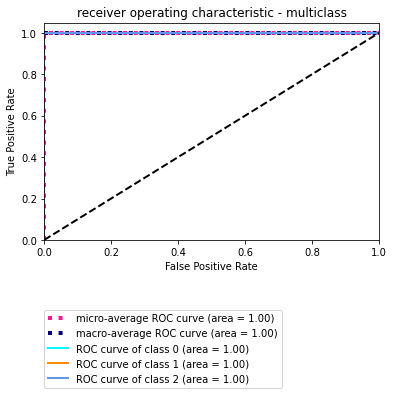

In [8]:
train_run = train_iris_func.run(inputs={'dataset': dataset},
                                params={'label_column': 'label'},local=True)

<a id='gs-run-ingest-func'></a>

### Reviewing the Run Output

You can view extensive run information and artifacts from Jupyter Notebook and the MLRun dashboard, as well as browse the project artifacts from the dashboard.

The following code extracts and displays the model from the training-job outputs.

In [9]:
train_run.outputs['my_model']

'store://artifacts/getting-started-iguazio/my_model:1676f91b289d48ba9fc6b0b81c9cade5'

Your project's artifacts directory contains the results for the executed training job.
The **plots** subdirectory has HTML output artifacts for the selected run iteration;
(the **data** subdirectory contains the artifacts for the test data set).

Use the following code to extract and display information from the run object &mdash; the accuracy that was achieved with the model, and the `confusion` and `roc` HTML output artifacts for the optimal run iteration.

In [10]:
print(f'Accuracy: {train_run.outputs["accuracy"]}')

Accuracy: 1.0



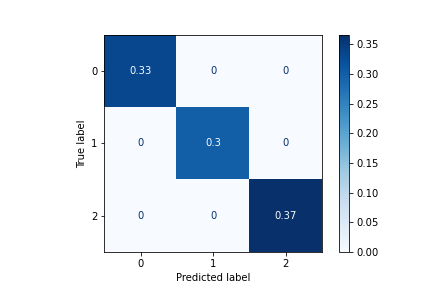

In [11]:
# Display HTML output artifacts
train_run.artifact('confusion-matrix').show()


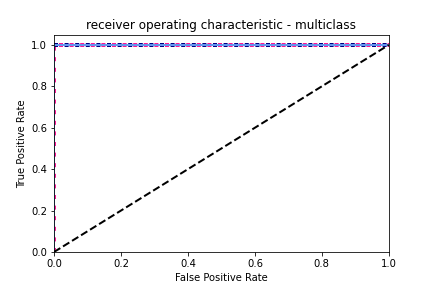

In [12]:
train_run.artifact('roc-multiclass').show()

<a id="gs-explore-data-w-pandas-df"></a>

### Exploring the Data with pandas DataFrames

Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [13]:
# Read your data set
df = train_run.artifact('test_set').as_df()
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


In [14]:
# Display statistics grouped by label
df.groupby(['label']).describe()

sepal length (cm)                                                   \
                  count      mean       std  min   25%   50%    75%  max   
label                                                                      
0                  10.0  5.070000  0.346570  4.7  4.80  4.95  5.325  5.7   
1                   9.0  6.011111  0.391933  5.6  5.70  6.00  6.200  6.8   
2                  11.0  6.781818  0.551032  6.1  6.45  6.70  6.850  7.9   

      sepal width (cm)            ... petal length (cm)      petal width (cm)  \
                 count      mean  ...               75%  max            count   
label                             ...                                           
0                 10.0  3.330000  ...              1.60  1.7             10.0   
1                  9.0  2.766667  ...              4.70  4.8              9.0   
2                 11.0  3.000000  ...              5.85  6.9             11.0   

                                                     
           mean       std  min  25%   50%  75%  max  
label                                                
0      0.250000  0.108012  0.1  0.2  0.25  0.3  0.4  
1      1.344444  0.166667  1.1  1.2  1.30  1.5  1.6  
2      2.118182  0.194001  1.8  2.0  2.20  2.3  2.3  

[3 rows x 32 columns]

<a id="gs-tutorial-2-step-explore-data-w-mlrun-func"></a>

## Step 3: Exploring the Data with an MLRun Marketplace Function

You can perform further data exploration by leveraging **the MLRun functions marketplace** (a.k.a. "the MLRun functions hub").
This marketplace is a centralized location for open-source contributions of function components that are commonly used in machine-learning development.
The location of the marketplace is centrally configured .
By default, it points to the [mlrun/functions](https://github.com/mlrun/functions/) GitHub repository.

This step uses the [`describe` marketplace function](https://github.com/mlrun/functions/tree/master/describe), which performs data exploration on a provided data set.
The function is used to extract information from your data set, analyze it, and visualize relevant information in different ways.

### Adding an Exploration Function

Use the `import_function` MLRun method, which adds or updates a function object in a project, to load the `describe` MLRun marketplace function into a new `describe` project function. 
The tutorial code sets the first `import_function` parameter &mdash; `url` &mdash; which identities the function to load.

> **Note:** MLRun supports multiple types of URL formats.
> The example uses the `hub://<function name>` format to point to the `describe` function-code directory in the MLRun functions marketplace (`'hub://describe'`).
> You can add `:<tag>` to this syntax to load a specific function tag &mdash; `hub://<function_name>:<tag>`; replace the `<function name>` and `<tag>` placeholders with the desired function name and tag.

In [15]:
describe = mlrun.import_function('hub://describe')

<a id="gs-tutorial-2-view-func-doc"></a>

### Viewing the Function Documentation

Use the `doc` method to view the embedded documentation of the `describe` function.

In [16]:
describe.doc()

function: describe
describe and visualizes dataset stats
default handler: summarize
entry points:
  summarize: Summarize a table
    context(MLClientCtx)  - the function context, default=
    table(DataItem)  - MLRun input pointing to pandas dataframe (csv/parquet file path), default=
    label_column(str)  - ground truth column label, default=None
    class_labels(List[str])  - label for each class in tables and plots, default=[]
    plot_hist(bool)  - (True) set this to False for large tables, default=True
    plots_dest(str)  - destination folder of summary plots (relative to artifact_path), default=plots
    update_dataset  - when the table is a registered dataset update the charts in-place, default=False


### Running the Exploration Function

Run the following code to execute the `describe` project function as a Kubernetes job by using the MLRun `run` method.
The returned run object is stored in a `describe_run` variable.

The location of the data set is the only input that you need to provide.
This information is provided as a `table` input artifact that points to the `table_set` output artifact of the `train_run` job that you ran in the previous step.

In [17]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table": train_run.outputs['test_set']})

> 2021-09-09 03:30:06,726 [info] starting run describe-summarize uid=453b3bc4ed644b3e9b62fc6284bc41a9 DB=http://mlrun-api:8080
> 2021-09-09 03:30:06,940 [info] Job is running in the background, pod: describe-summarize-42fp2
> 2021-09-09 03:30:16,074 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iguazio,...84bc41a9,0,Sep 09 03:30:10,completed,describe-summarize,v3io_user=iguaziokind=jobowner=iguaziohost=describe-summarize-42fp2,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


> 2021-09-09 03:30:16,272 [info] run executed, status=completed


### Reviewing the Run Output

The output cell for your code execution contains a run-information table.
You can also view run information in the MLRun dashboard; see the output-review information in Step 2, only this time look for the `describe-summarize` job and related artifacts.

The `describe` function generates three HTML output artifacts, which provide visual insights for your data set &mdash; `histograms`, `imbalance`, and `correlation`.
The artifacts are stored as HTML files in your project's artifacts directory, under **&lt;project artifacts path&gt;/jobs/plots/**.
The following code displays the artifact files in the notebook.


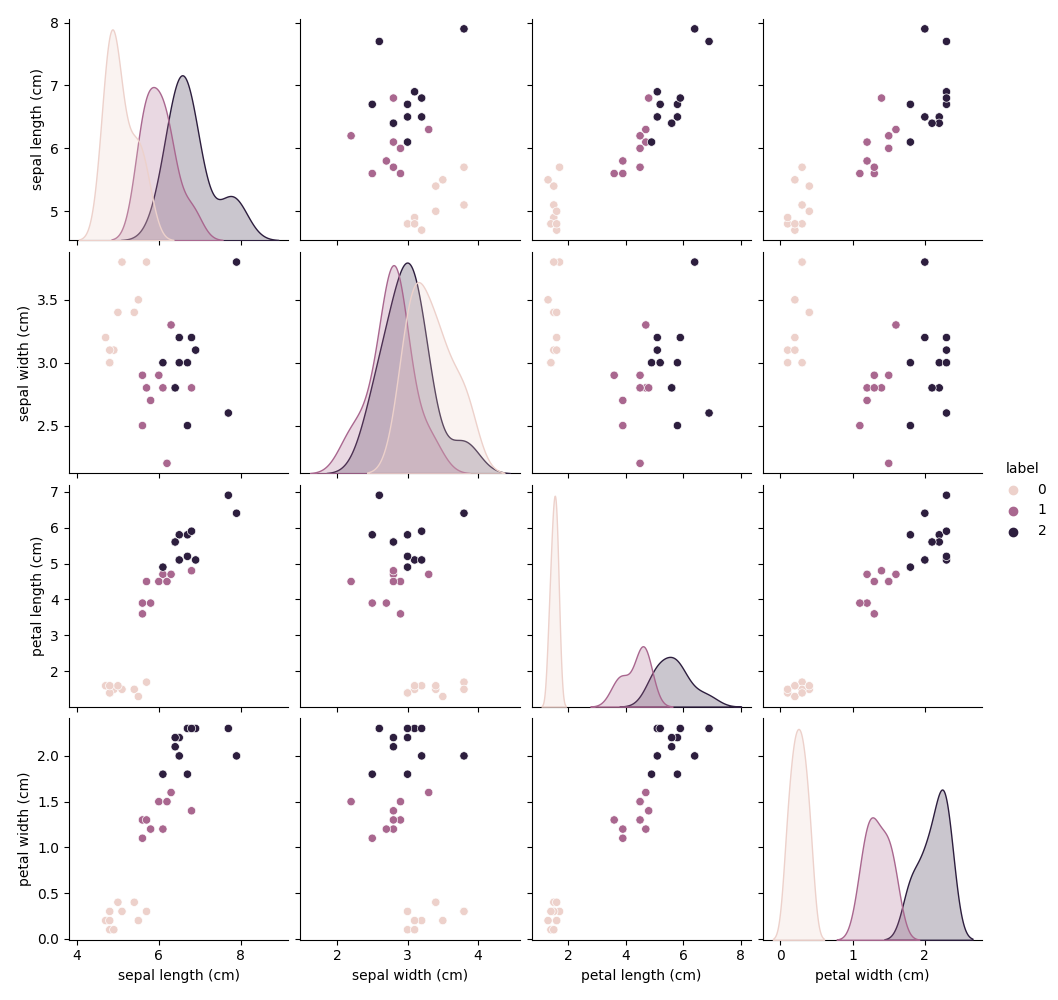

In [18]:
# Display the `histograms` artifact
describe_run.artifact('histograms').show()


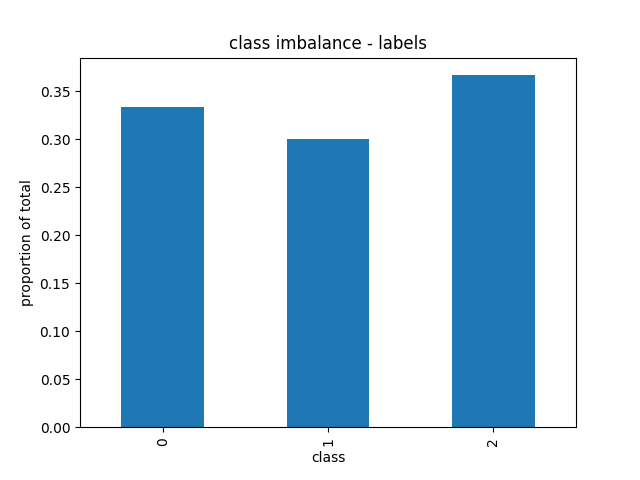

In [19]:
# Display the `imbalance` artifact
describe_run.artifact('imbalance').show()


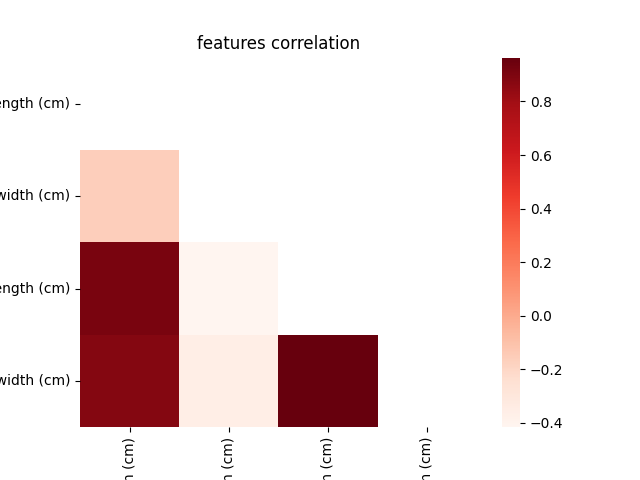

In [20]:
# Display the `correlation` artifact
describe_run.artifact('correlation').show()

<a id="gs-tutorial-2-step-test-model"></a>

## Step 4: Testing Your Model

Now that you have a trained model, you can test it:
run a task that uses the [`test_classifier` marketplace function](https://github.com/mlrun/functions/tree/master/test_classifier) to run the selected trained model against the test data set, as returned for the training task (`train`) in the previous step.

<a id="gs-tutorial-2-add-test-function"></a>

### Adding a Test Function

Run the following code to add to your project a `test` function that uses the `test_classifier` marketplace function code, and create a related `test` function object.

In [21]:
test = mlrun.import_function('hub://test_classifier')

<a id="gs-tutorial-2-run-model-testing-job"></a>

### Running a Model-Testing Job

Configure parameters for the test function (`params`), and provide the selected trained model from the `train_run` job as an input artifact (`inputs`).

In [22]:
test_run = test.run(name="test",
                    params={"label_column": "label"},
                    inputs={"models_path": train_run.outputs['my_model'],
                            "test_set": train_run.outputs['test_set']})

> 2021-09-09 03:30:16,460 [info] starting run test uid=a03439aecf454621b254215b34ad6665 DB=http://mlrun-api:8080
> 2021-09-09 03:30:16,687 [info] Job is running in the background, pod: test-k6llw
> 2021-09-09 03:30:22,124 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iguazio,...34ad6665,0,Sep 09 03:30:20,completed,test,v3io_user=iguaziokind=jobowner=iguaziohost=test-k6llw,models_pathtest_set,label_column=label,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds


> 2021-09-09 03:30:22,960 [info] run executed, status=completed


<a id="gs-test-model-run-output-review"></a>

### Reviewing the Run Output

Check the output information for your run in Jupyter Notebook and on the MLRun dashboard.

Use the following code to display information from the run object &mdash; the accuracy of the model, and the `confusion` and `roc` HTML output artifacts.

In [23]:
print(f'Test Accuracy: {test_run.outputs["accuracy"]}')

Test Accuracy: 1.0



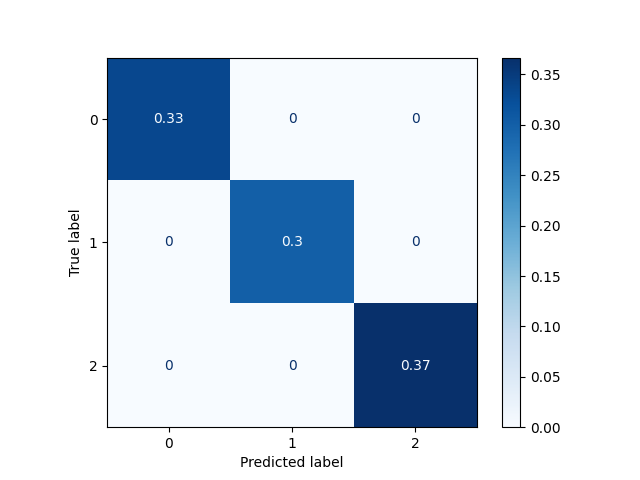

In [24]:
test_run.artifact('confusion-matrix').show()


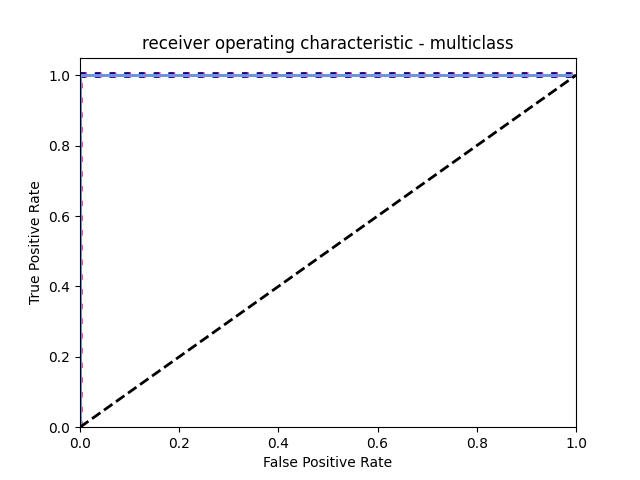

In [25]:
test_run.artifact('roc-multiclass').show()

<a id="gs-tutorial-2-done"></a>

## Done!

Congratulation! You've completed Part 2 of the MLRun getting-started tutorial.
Proceed to [Part 3](03-model-serving.ipynb) to learn how to deploy and server your model using a serverless function.